In [407]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [585]:
# class Value:
#     def __init__(self, data, _children=(), _op='', label=''):
#         self.data = data
#         self.grad = 0.0
#         self._backward = lambda: None
#         self.prev = set(_children)
#         self._op = _op
#         self.label = label
#     def __repr__(self):
#         return f"Value(data={self.data})"
#     def __add__(self, other):
#         other = other if isinstance(other, Value) else Value(other)
#         out = Value(self.data + other.data, (self, other), '+')
#         def _backward():
#             self.grad += 1.0 * out.grad
#             other.grad += 1.0 * out.grad
#         out._backward = _backward
#         return out
        
#     def __mul__(self, other):
#         other = other if isinstance(other, Value) else Value(other)
#         out = Value(self.data * other.data, (self, other), '*')
#         def _backward():
#             self.grad += other.data * out.grad
#             other.grad += self.data * out.grad
#         out._backward = _backward
#         return out

#     def __rmul__(self, other):
#         return self * other

#     def exp(self):
#         x = self.data
#         out = Value(math.exp(x), (self, ), 'exp')
#         def _backward():
#             self.grad += out.data * out.grad
#         out._backward = _backward
#         return out

#     def __neg__(self):
#         return self * -1
        
#     def __sub__(self, other):
#         return self + (-other)

#     def __truediv__(self, other):
#         return self * other ** -1

#     def __pow__(self, other):
#         assert isinstance(other, (int, float)), "Only supporting powers for now"
#         out = Value(self.data ** other, (self, ), f"**{other}")
#         def _backward():
#             self.grad = other * ((self.data) ** (other - 1)) * out.grad
#         out._backward = _backward
#         return out
        
#     def tanh(self):
#         n = self.data
#         t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
#         out = Value(t, (self, ), 'tanh')
#         def _backward():
#             self.grad += (1.0 - t**2) * out.grad
#         out._backward = _backward
#         return out

#     def backward(self):
#         topo = []
#         visited = set()
#         def build_topo(v):
#             if v not in visited:
#                 visited.add(v)
#                 for child in v.prev:
#                     build_topo(child)
#                 topo.append(v)
#         build_topo(self)
#         self.grad = 1.0
#         for x in reversed(topo):
#             x._backward()

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self.prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


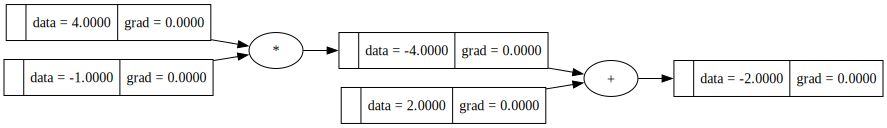

In [413]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s |  data = %.4f | grad = %0.4f}" % (n.label, n.data, n.grad,), shape='record')  # Fixed formatting
        if n._op: 
            op_uid = uid + n._op
            dot.node(name=op_uid, label=n._op)
            dot.edge(op_uid, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)  
    return dot
    
# draw_dot(L)

In [190]:
# def lol():
#     h = 0.0001
#     a = Value(2.0, label='a')
#     b = Value(-3.0, label='b')
#     c = Value(10.0, label='c')
#     f = Value(-2.0, label='f')
#     e = a * b; e.label = 'e'
#     d = e + c; d.label='d'
#     L = d * f; L.label = 'L'

#     L1 = L.data
#     a = Value(2.0 + h, label='a')
#     b = Value(-3.0, label='b')
#     c = Value(10.0, label='c')
#     f = Value(-2.0, label='f')
#     e = a * b; e.label = 'e'
#     d = e + c; d.label='d'
#     L = d * f ; L.label = 'L'
#     L2 = L.data

#     print((L2 - L1)/h)
# lol()

In [192]:
# L.grad = 1.0
# d.grad = -2.0
# f.grad = 4.0
# e.grad = -2.0
# c.grad = -2.0
# b.grad = -4.0
# a.grad = 6

In [400]:
# plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [396]:
# x1 = Value(2.0, label='x1')
# x2 = Value(0.0, label='x2')

# # Weights of the neuron
# w1 = Value(-3.0, label='w1')
# w2 = Value(1.0, label='w2')

# # bias of the neuron
# b = Value(6.88137358, label='b')
# x1w1 = x1 * w1; x1w1.label = 'x1*w1';
# x2w2 = x2 * w2; x2w2.label = 'x2*w2';
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
# o.backward()
# draw_dot(o)

In [398]:
# x1 = Value(2.0, label='x1')
# x2 = Value(0.0, label='x2')

# # Weights of the neuron
# w1 = Value(-3.0, label='w1')
# w2 = Value(1.0, label='w2')

# # bias of the neuron
# b = Value(6.88137358, label='b')
# x1w1 = x1 * w1; x1w1.label = 'x1*w1';
# x2w2 = x2 * w2; x2w2.label = 'x2*w2';
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n = x1w1x2w2 + b; n.label = 'n'
# e = (2*n).exp(); e.label = 'e'
# o = (e - 1)/(e + 1); o.label = 'o'
# o.backward()
# draw_dot(o)

In [955]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8827720620584214)

In [957]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]

In [959]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8827720620584214),
 Value(data=-0.8186672220820571),
 Value(data=-0.869348761061324),
 Value(data=-0.7333030543504051)]

In [961]:
# Loss
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))
loss.backward()
loss

Value(data=6.599121438471812)

In [901]:
# draw_dot(loss)

In [905]:
n.layers[0].neurons[0].w[0].data

-0.13914170874174678

In [967]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))

    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.05913603029162784
1 0.05518643539543382
2 0.05170960513703715
3 0.04862673639523206
4 0.04587548712448161
5 0.04340590936270617
6 0.04117752831226825
7 0.03915720815090437
8 0.03731756836771784
9 0.03563579205676177
10 0.03409271767867353
11 0.03267213877383917
12 0.031360258230519605
13 0.030145258805627014
14 0.02901696205798944
15 0.027966555210412733
16 0.026986370698602574
17 0.026069706946119424
18 0.025210681663317483
19 0.0244041110025913


In [969]:
ypred

[Value(data=0.9111599797338826),
 Value(data=-0.9018848739807421),
 Value(data=-0.943253403829067),
 Value(data=0.939462345016136)]

In [973]:
# draw_dot(ypred[0])